# MNIST: Log-Linear Model v.s. Autoencoder

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

from joblib import Parallel, delayed

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import ld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def renormalize_image(image, threshold=False, threshold_value=10):
    """
    Renormalize an image such that pixel values are between 0 and 255.
    Optionally, set small pixel values to 0.

    Parameters:
    - image: numpy array with shape (28, 28)
    - threshold: bool, if True, set small pixel values to 0
    - threshold_value: int, the value below which pixels are set to 0 (if threshold is True)

    Returns:
    - renormalized_image: numpy array with shape (28, 28), pixel values between 0 and 255
    """
    # Ensure the image is a numpy array
    image = np.array(image)

    # Renormalize pixel values to be between 0 and 255
    min_val = np.min(image)
    max_val = np.max(image)
    renormalized_image = 255 * (image - min_val) / (max_val - min_val)

    # Apply threshold if needed
    if threshold:
        renormalized_image[renormalized_image < threshold_value] = 0

    return renormalized_image.astype(np.uint8)

def vectorize_tensor(T, B):
    """
    Vectorizes the tensor T by selecting only the indices in B.

    Parameters:
    - T: numpy array of shape (num_samples, ...)
    - B: list of indices to select from each sample

    Returns:
    - V: vectorized representation of T of shape (num_samples, len(B))
    """
    num_samples = T.shape[0]
    V = np.zeros((num_samples, len(B)))
    for i in range(num_samples):
        for j, idx in enumerate(B):
            V[i, j] = T[i, *idx]
    return V

def reconstruct_tensor(V, T_shape, B):
    """
    Reconstructs the tensor T from its vectorized representation V.

    Parameters:
    - V: vectorized representation of T of shape (num_samples, len(B))
    - T_shape: original shape of the tensor T
    - B: list of indices that were used to create the vectorized representation

    Returns:
    - T: reconstructed tensor with the original shape, missing values filled with zero
    """
    num_samples = V.shape[0]
    T = np.zeros(T_shape)
    for i in range(num_samples):
        for j, idx in enumerate(B):
            T[i, *idx] = V[i, j]
    return T

## Setup

### Dataset

In [21]:
D = 28*28
S = (7, 2, 2, 7, 2, 2)
train_size = 100
num_new_samples = 20
plot_num = 20
paper_plot_num = 1
bandwidth = 0.05
k = 20
eps = np.asarray(1.0e-5)

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)

save_dir = './data/MNIST_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Save images by class
    for class_label in range(10):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        basis = np.where(train_dataset.targets.numpy() == class_label)[0]
        for i, idx in enumerate(basis):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

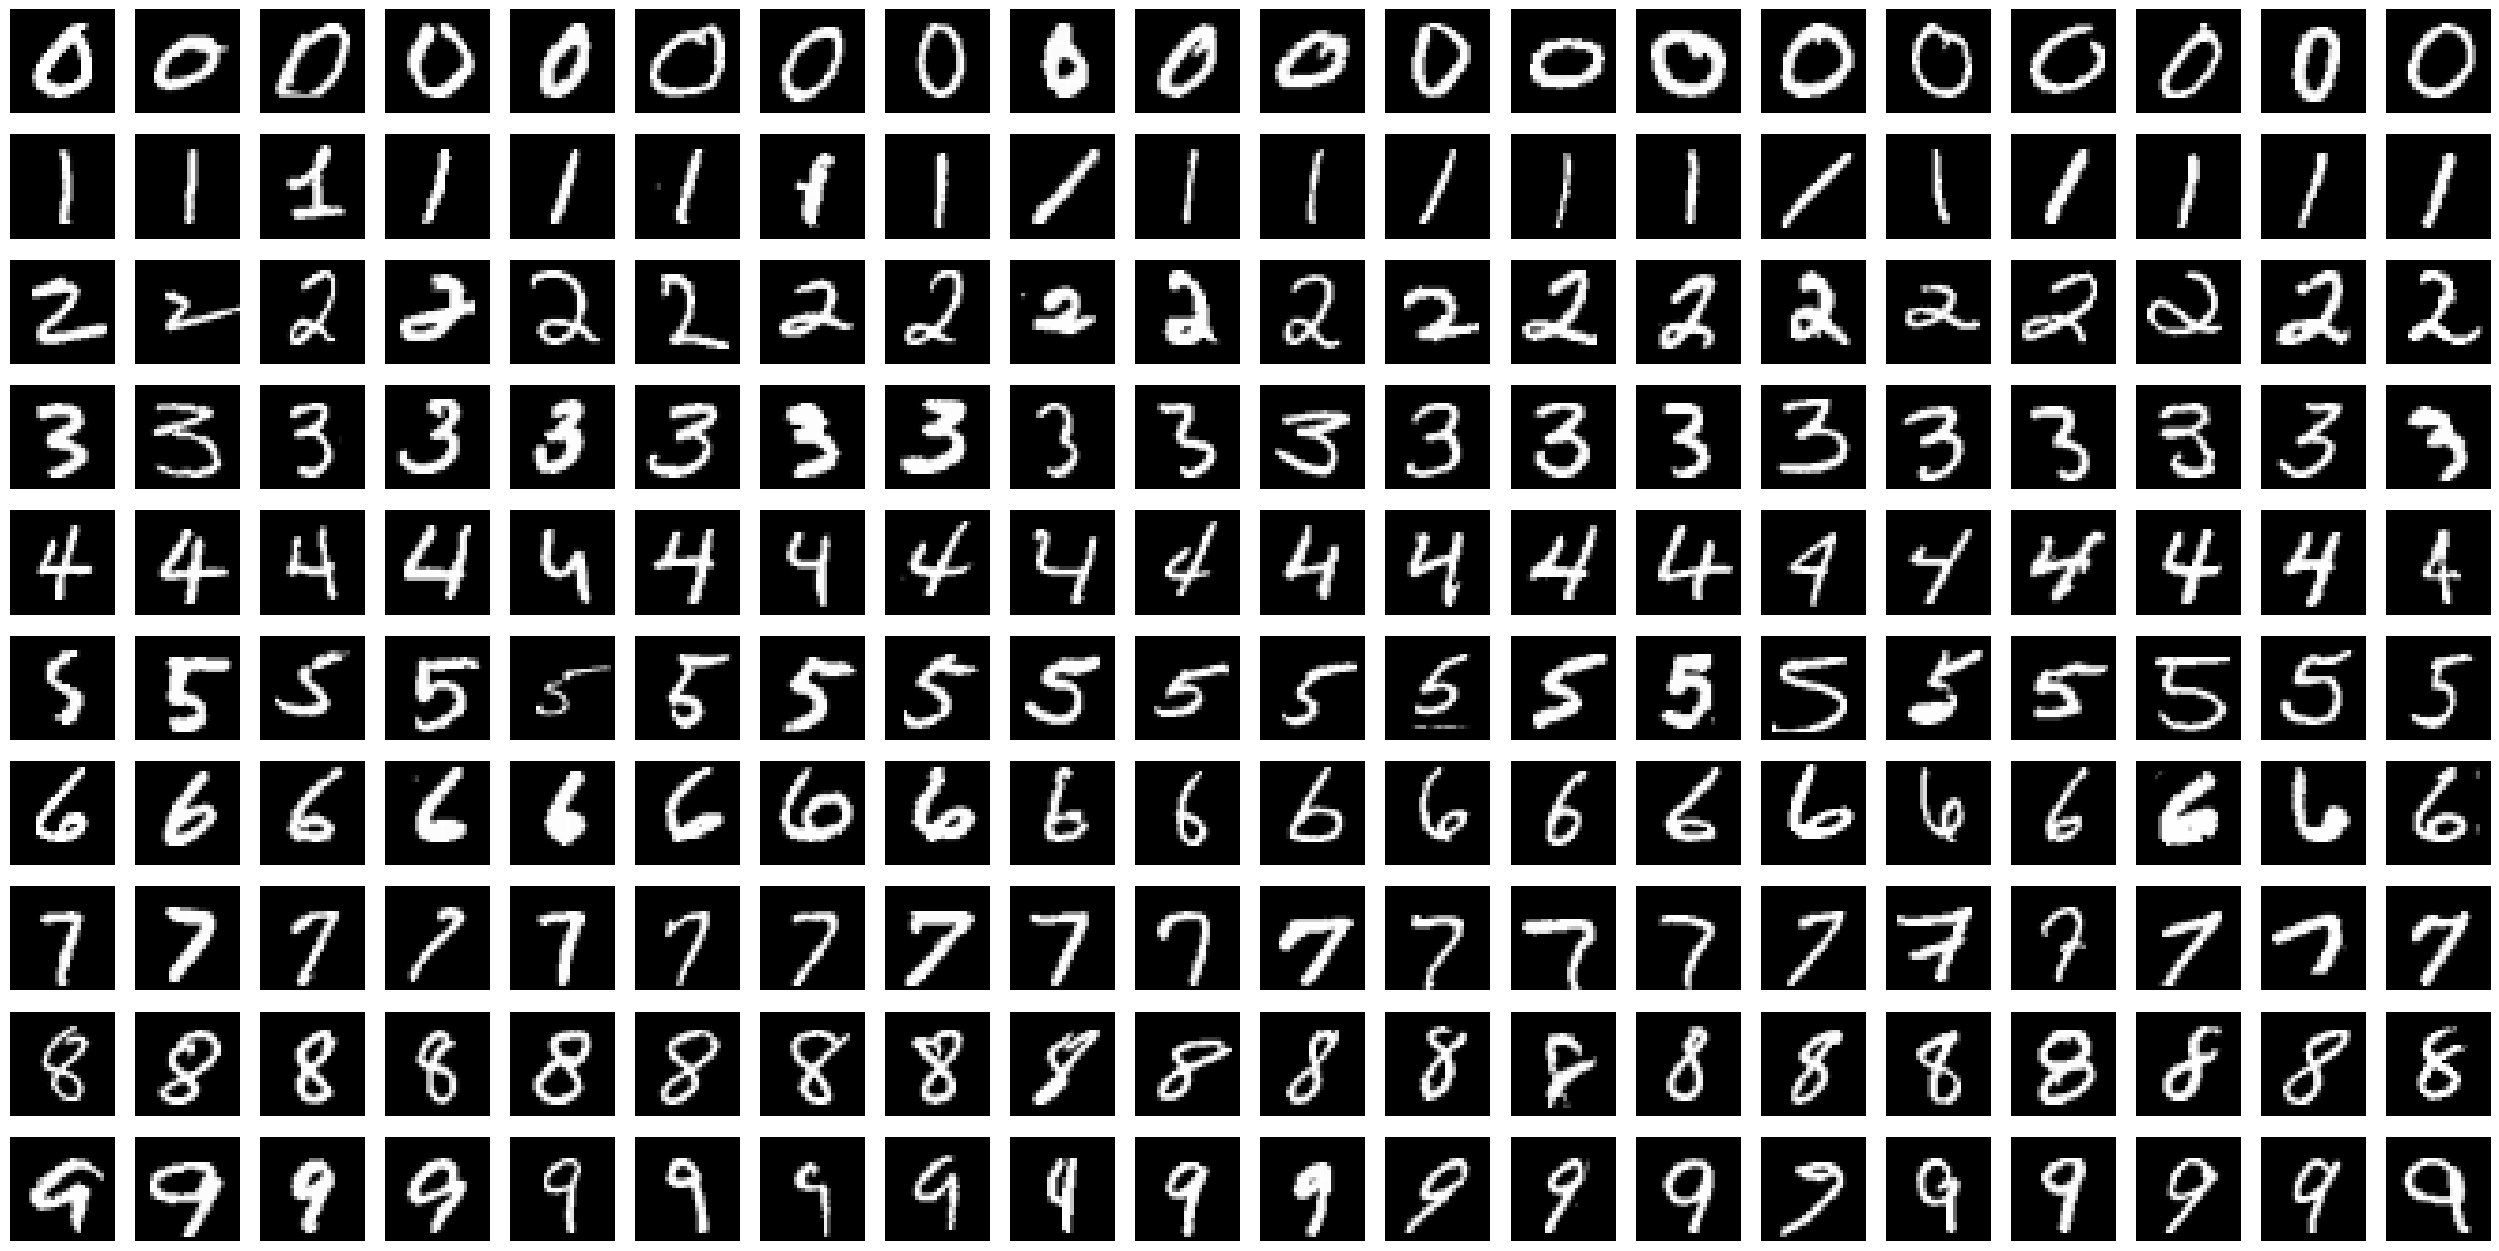

In [5]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

P_digit = []
original_data = []

for digit in range(10):
    class_folder = os.path.join(save_dir, str(digit))
    images = load_images_from_folder(class_folder, max_images=train_size)

    P = []
    for i in range(len(images)):
        img = images[i]
        img = img.resize((28, 28))
        original_data.append(np.asarray(img))
        array_obj = np.asarray(img).reshape(S)
        P.append(array_obj)

    P_digit.append(np.array(P))

# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][i].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

### Build Dataloader for Later

In [6]:
# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array): NumPy array of shape (num, 28*28)
            labels (numpy array): Corresponding labels for each image
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and label for a given index
        image = self.data[idx].reshape(28, 28).astype(np.float32) / 255.0 # Reshape from 28*28 to 28x28
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_data_original = np.array(original_data)
labels = np.repeat(np.arange(10), train_size)
custom_train_dataset = CustomDataset(train_data_original, labels, transform=transforms.ToTensor())
train_loader_original = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

## Data Augmentation with Log-Linear Model

### Legendre Decomposition (Many-Body Approximation)

In [7]:
B_LD = ld.default_B(S, 2, cp.get_array_module(P[0]))

print(B_LD.shape)

def LD_helper(i, digit):
    _, _, scaleX, Q, theta = ld.LD(P_digit[digit][i], B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
    return (scaleX, Q, theta)

results = Parallel(n_jobs=30)(delayed(LD_helper)(i, digit) for i in range(train_size) for digit in range(10))

scaleX_digit = []
Q_digit = []
theta_digit = []
X_recons_digit = []

for digit in range(10):
    scaleX_list = []
    Q_list = []
    theta_list = []
    X_recons_list = []
    for i in range(train_size):
        result = results[i*10 + digit]

        scaleX_list.append(result[0])
        Q_list.append(result[1])
        theta_list.append(result[2])
        X_recons = (result[1] * result[0]).astype(np.int32)
        X_recons_list.append(X_recons)

    scaleX_digit.append(np.array(scaleX_list))
    Q_digit.append(np.array(Q_list))
    theta_digit.append(np.array(theta_list))
    X_recons_digit.append(np.array(X_recons_list))

(107, 6)


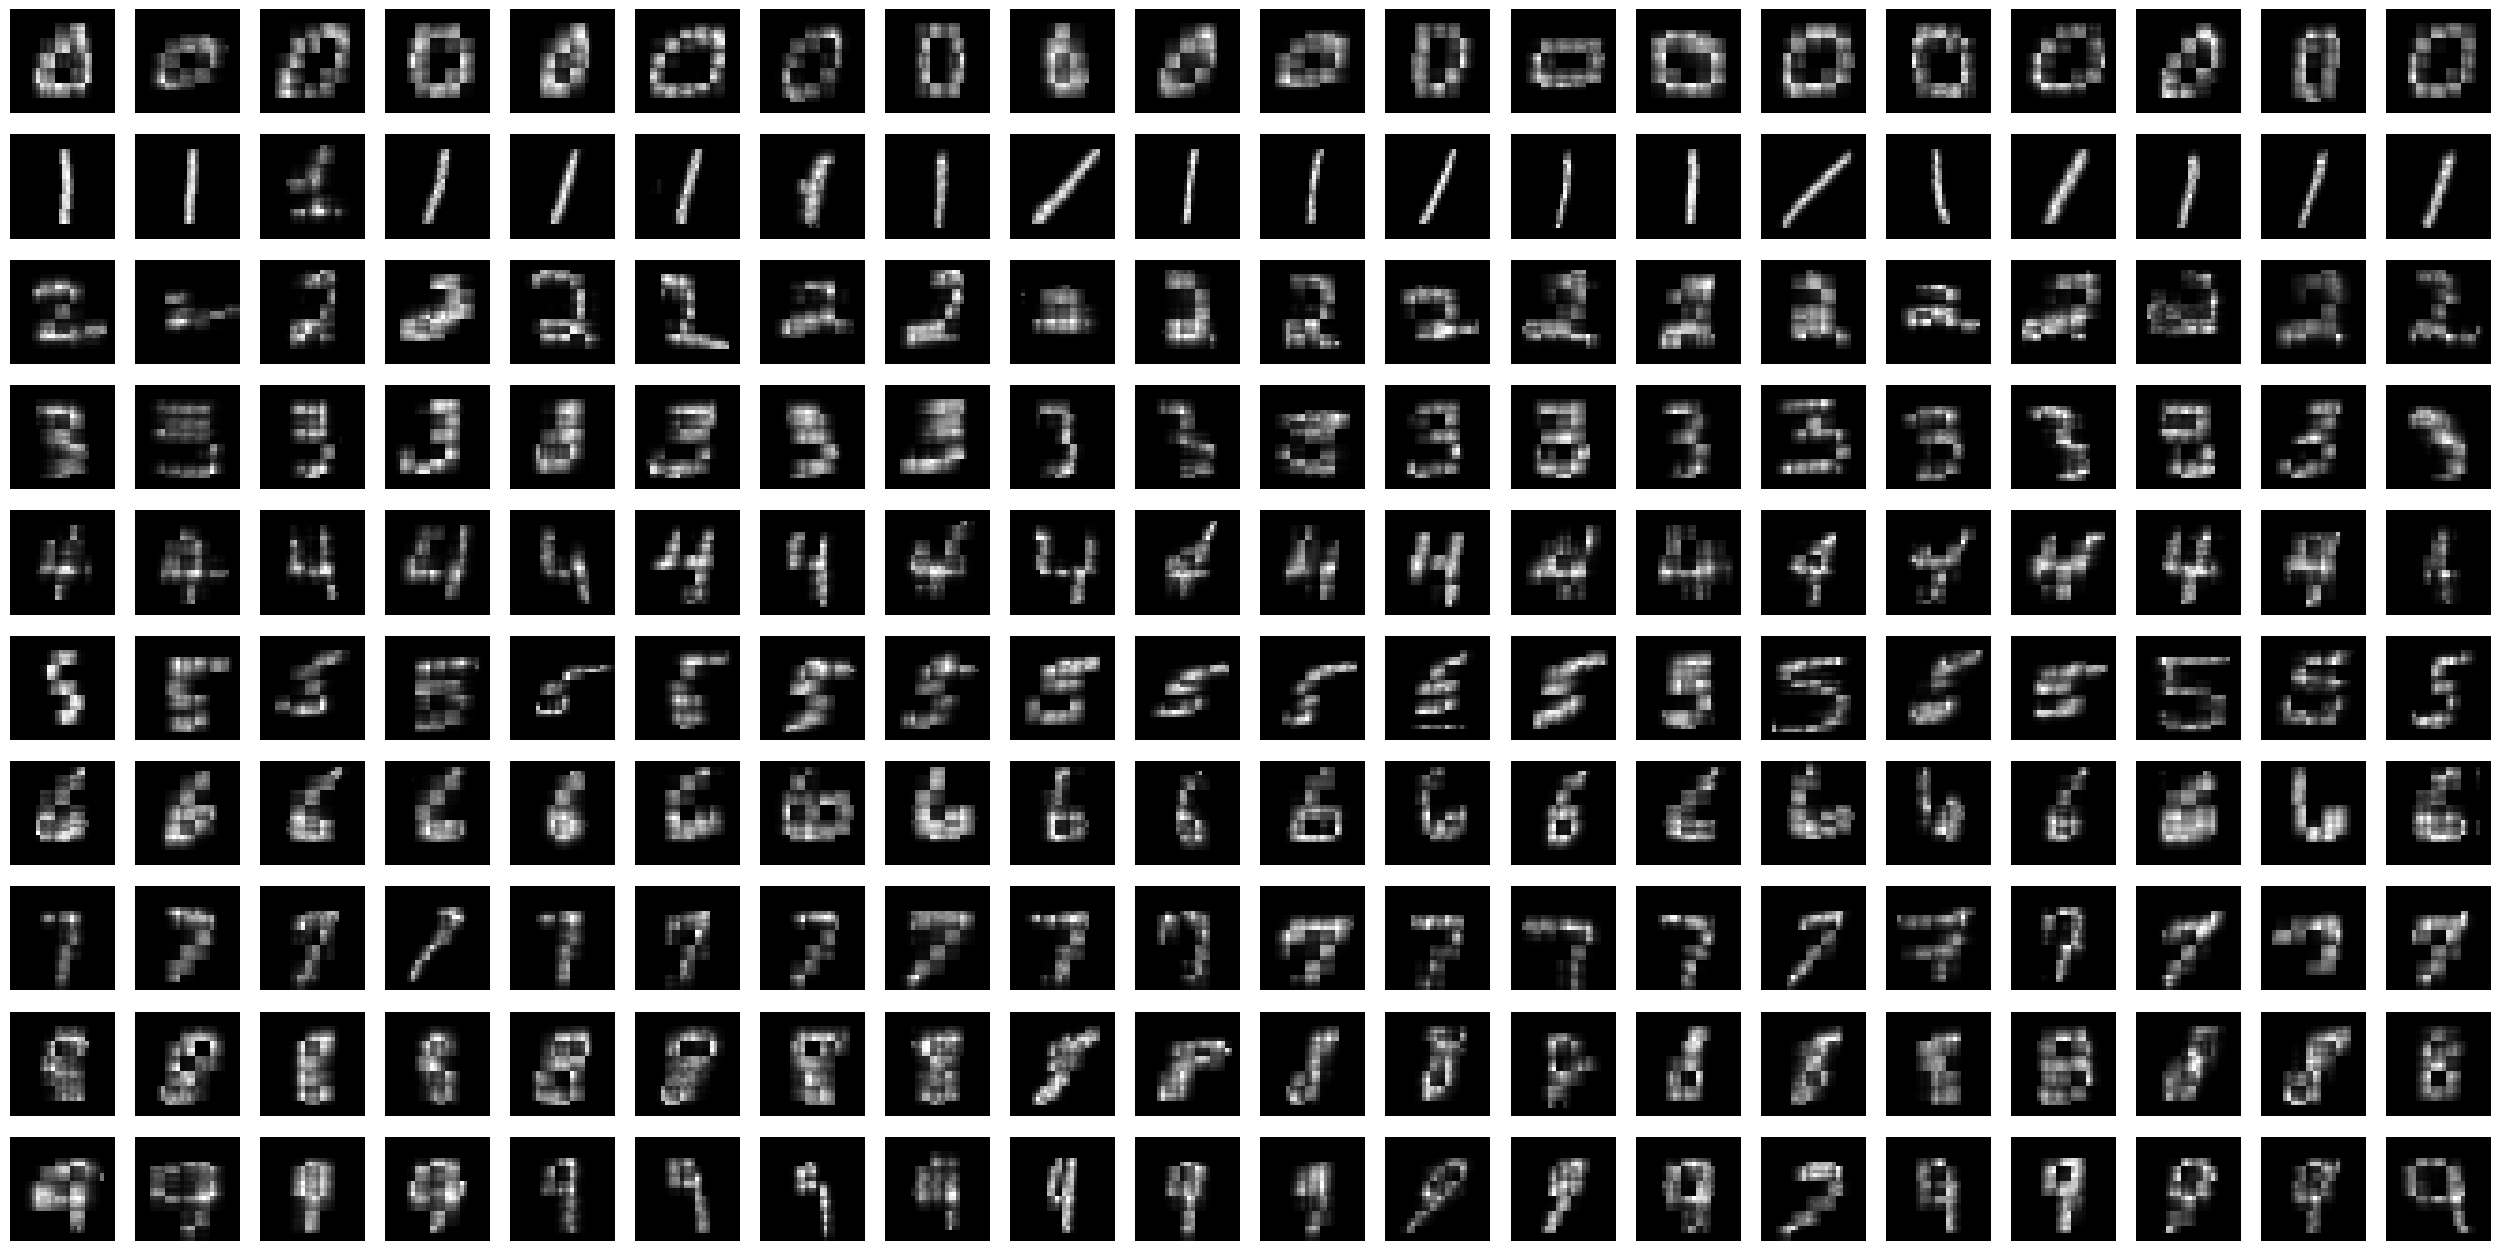

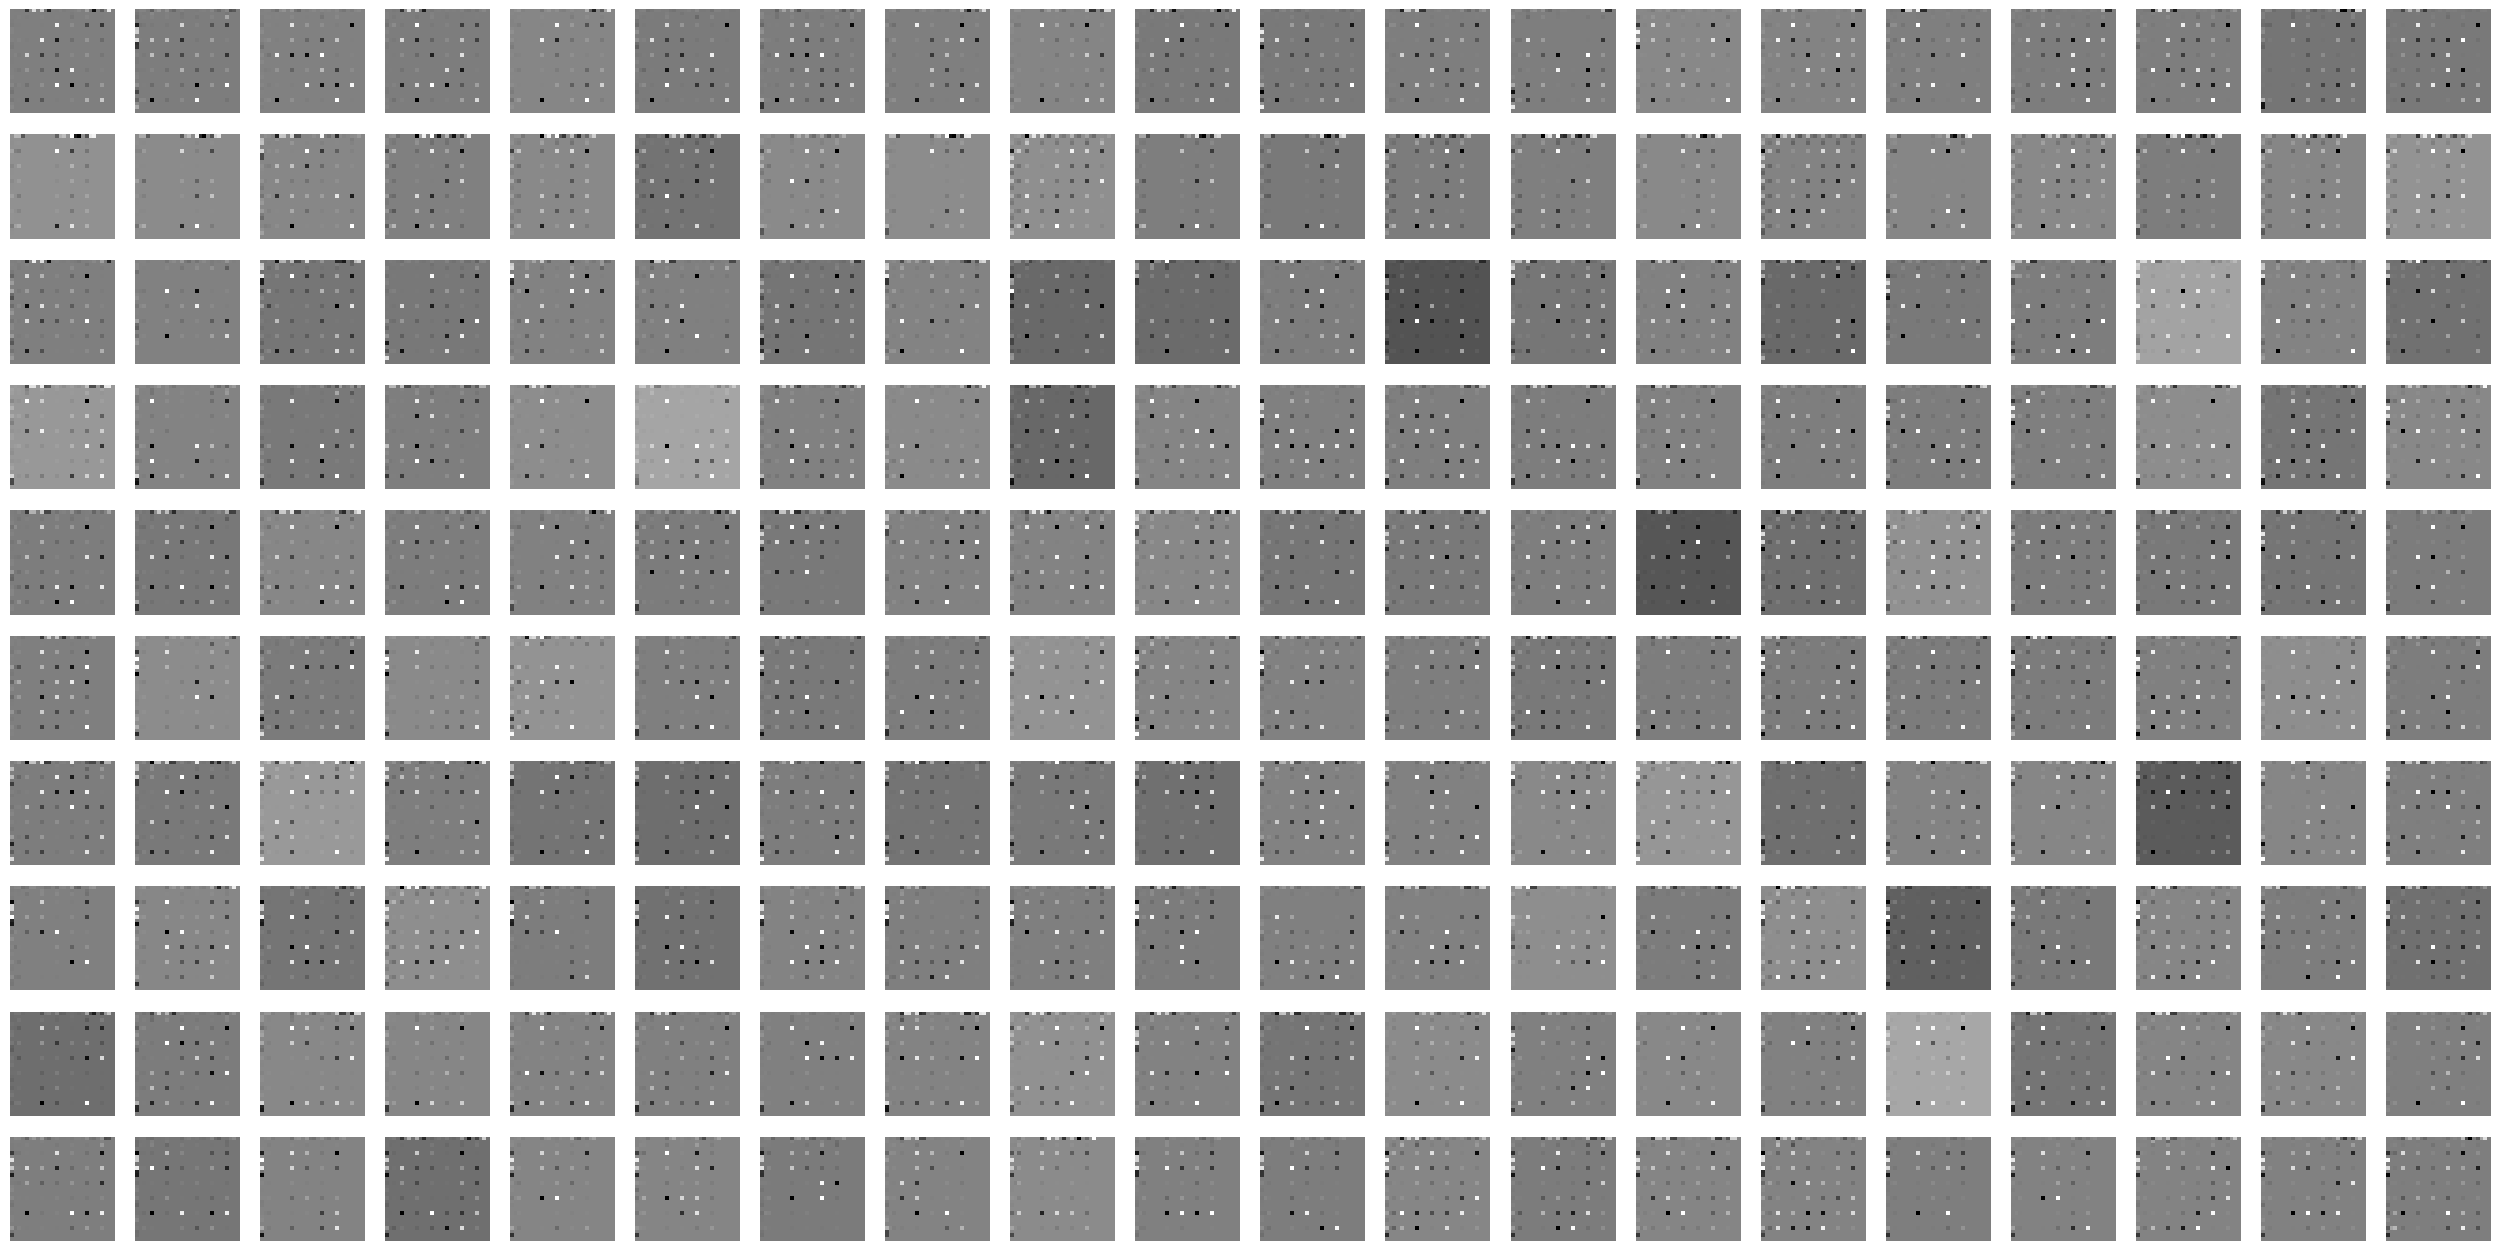

In [8]:
# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='coolwarm', vmin=-15, vmax=15)
        plt.axis('off')  # Hide axes

plt.show()

#### Construct Local-Data Sub-Manifold

In [10]:
# Construct the constrained coordinates
# B_BP = ld.block_B([14, 14], [15, 15])
B_BP = ld.default_B(S, 1, cp.get_array_module(P[0]))

print(B_BP.shape)

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_digit = []

for digit in range(10):
    eta_hat_list = []
    for i in range(P_digit[digit].shape[0]):
        xp = cp.get_array_module(P_digit[digit][i])
        P = (P_digit[digit][i] + eps) / scaleX_digit[digit][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)

    eta_hat_digit.append(cp.asarray(eta_hat_list))

(17, 6)


### Interpolation

In [11]:
def interpolate_sum(theta_start, theta_end, interpolate_num, interpolate_B):
    """
    Perform interpolation between theta_start and theta_end and sum over specified indices.

    Parameters:
    theta_start (np.ndarray): Starting tensor.
    theta_end (np.ndarray): Ending tensor.
    interpolate_num (int): Number of interpolation steps.
    interpolate_B (list of tuples): Indices to sum over.

    Returns:
    np.ndarray: Array of interpolated tensors.
    """
    # Get the shape of the tensor
    tensor_shape = theta_start.shape

    # Create an array to store the interpolated tensors
    interpolated_thetas = np.zeros((interpolate_num,) + tensor_shape)

    # Iterate over the interpolation steps
    for i in range(interpolate_num):
        t = i / (interpolate_num - 1)  # Compute interpolation factor

        # Perform interpolation and sum over specified indices
        for basis in interpolate_B:
            index_slices = [slice(None)] * len(tensor_shape)
            index_slices = list(basis)
            interpolated_thetas[i][tuple(index_slices)] = (
                theta_start[tuple(index_slices)] + t * (theta_end[tuple(index_slices)] - theta_start[tuple(index_slices)])
            )

    return interpolated_thetas

In [12]:
theta_all = np.vstack(theta_digit)
scaleX_all = np.concatenate(scaleX_digit, axis=0)
P_all = np.vstack(P_digit)
eta_hat_all = np.vstack(eta_hat_digit)

In [26]:
# start_digit, end_digit = 1, 9
start_idx, end_idx = 2, 4

B_interpolate = ld.default_B(S, len(S), cp.get_array_module(P_digit[0][0]))
# B_interpolate = ld.block_B([1, 0, 0, 1, 0, 0], [6, 1, 1, 6, 1, 1])

for start_digit in range(10):
    for end_digit in range(10):
        theta_start, theta_end = theta_digit[start_digit][start_idx], theta_digit[end_digit][end_idx]

        interpolate_num = 20

        interpolate_theta = interpolate_sum(theta_start, theta_end, interpolate_num, B_interpolate)

        def BP_helper(i):
            N = ld.kNN(interpolate_theta[i], np.vstack(theta_digit), k=k)
            avg_scale = np.mean(scaleX_all[N])
            avg_eta_hat = np.mean(eta_hat_all[N], axis=0)
            _, _, P, theta = ld.BP(interpolate_theta[i], [(P_all[j] + eps) / scaleX_all[j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
            X_recons_ = (P).astype(np.int32).reshape(-1)
            return (P, theta, X_recons_)

        results = Parallel(n_jobs=30)(delayed(BP_helper)(i) for i in range(interpolate_num))

        interpolate_P_BP = []
        interpolate_theta_BP = []
        interpolate_X_recons = []

        for i in range(interpolate_num):
            interpolate_P_BP.append(results[i][0])
            interpolate_theta_BP.append(results[i][1])
            interpolate_X_recons.append(results[i][2])

        interpolate_P_BP = np.array(interpolate_P_BP)
        interpolate_theta_BP = np.array(interpolate_theta_BP)
        interpolate_X_recons = np.array(interpolate_X_recons)

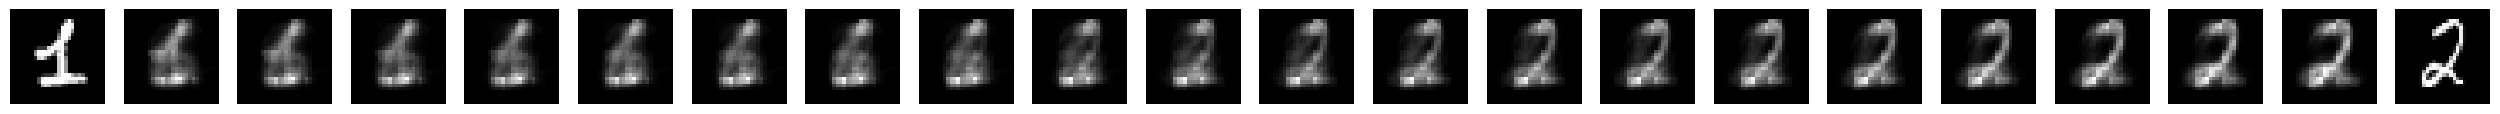

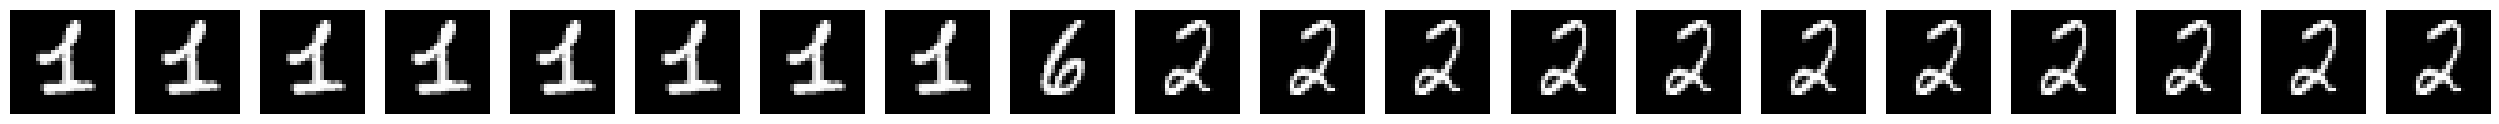

In [25]:
plt.figure(figsize=(32, 3))
plt.subplot(1, interpolate_num+2, 1)
plt.imshow(P_digit[start_digit][start_idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
plt.axis('off')
for i in range(interpolate_num):
    plt.subplot(1, interpolate_num+2, i + 2)
    plt.imshow(renormalize_image(interpolate_X_recons[i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.subplot(1, interpolate_num+2, interpolate_num + 2)
plt.imshow(P_digit[end_digit][end_idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 3))

for i in range(interpolate_num):
    norm = [np.linalg.norm(interpolate_X_recons[i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_all]
    idx = np.argmin(norm)
    # print(f"Nearest distance: new sample {i} and training sample {idx}: {norm[idx]}")

    plt.subplot(1, interpolate_num, i+1)
    plt.imshow(P_all[idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')  # Hide axes

plt.show()